# CNN Model

I think a simple CNN could give me pretty good results, so I'm going to start slowly and build the most basic CNN possible, one convulution layer, 1 hidden layer, and one output layer. I'll continue to build the model and tune parameters and then implement my idea for a 1D convolution layer that combines band_1 and band_2. If results from that look promising then I'm going to extend that 1D correlation to incorporate the incident angle.

Before all the good stuff, I need to convert the bands into 75x75 images, and possibly work with a bootstrap sample if the results are slow. However, considering that the images are small and only have 1 channel, I think this CPU VM will do the job.

I think a simple CNN could give me pretty good results, so I'm going to start slowly and build the most basic CNN possible, one convulution layer, 1 hidden layer, and one output layer. I'll continue to build the model and tune parameters and then implement my idea for a 1D convolution layer that combines band_1 and band_2. If results from that look promising then I'm going to extend that 1D correlation to incorporate the incident angle.

Before all the good stuff, I need to convert the bands into 75x75 images, and possibly work with a bootstrap sample if the results are slow. However, considering that the images are small and only have 1 channel, I think this CPU VM will do the job.

In [1]:
from utils import *
from fastai import *

Using TensorFlow backend.


In [2]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [77]:
reduce_lr = ReduceLROnPlateau(patience=1)

In [48]:
batch_size=64

In [3]:
K.set_image_data_format('channels_last')

In [4]:
path = os.curdir + '/data/processed/'
train_json = path + 'train.json'

In [5]:
if os.path.exists(path + 'models/')==False:
    os.mkdir(path + 'models/')
model_path = path + 'models/'

## JSON Data Setup

In [6]:
#train = pd.read_json(train_json)
#train = train.replace(to_replace='na', value=np.nan)

In [7]:
#this will change the array into images, without the 1 dimension in front keras returns a valid range exceeded error
#band_1 = np.array([np.array(band).astype(np.float32).reshape(1,75,75) for band in train.band_1])
#band_2 = np.array([np.array(band).astype(np.float32).reshape(1,75,75) for band in train.band_2])

In [8]:
#to stack them I need to remove the 1 in the reshape, the stacking takes care of the channel number
#band_1_s = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train.band_1])
#band_2_s = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train.band_2])
#band_t = np.stack([band_1_s, band_2_s], axis=3)
#bands = np.stack([band_1_s, band_2_s, (band_1_s+band_2_s)/0.5], axis=3)

In [9]:
#this will cause roughly 20% of the training set to be split out for validation
#msk = np.random.rand(len(train.band_1))<0.8

In [10]:
#trn_data = bands[msk]
#val_data = bands[~msk]

In [11]:
#save_array(path + 'val_data.bc', val_data)
#save_array(path + 'trn_data.bc', trn_data)

In [12]:
val_data = load_array(path + 'val_data.bc')
trn_data = load_array(path + 'trn_data.bc')

In [13]:
trn_data.shape

(1301, 75, 75, 3)

In [14]:
#band_1 and band_2 share the same labels
#trn_labels = train.is_iceberg[msk]
#val_labels = train.is_iceberg[~msk]

In [15]:
#save_array(path + 'val_labels.bc', val_labels)
#save_array(path + 'trn_labels.bc', trn_labels)

In [16]:
val_labels = load_array(path + 'val_labels.bc')
trn_labels = load_array(path + 'trn_labels.bc')

In [17]:
trn_labels.shape

(1301,)

## Old Stuff

### Basic Model

Eventually, once I start incorporating both layers I'll need to switch to the functional API, but for now I just use sequential models (nevermind I should learn the functional API better anyway)

In [462]:
def simple_cnn():
    input_1 = Input(shape=(3,75,75))
    cnn = BatchNormalization()(input_1)
    #cnn = Conv2D(nb_filter=16, nb_row=3, nb_col=3, activation='relu')(cnn)
    #cnn = MaxPooling2D((2,2))(cnn)
    cnn = Flatten()(cnn)
    #cnn = Dense(32, activation='relu')(cnn)
    cnn = Dense(1, activation='sigmoid')(cnn)
    
    simple_cnn = Model(inputs=input_1, outputs=cnn)
    simple_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return simple_cnn

In [463]:
model = simple_cnn()

In [464]:
trn_data.shape

(1297, 3, 75, 75)

In [465]:
model.fit(trn_data, trn_labels, batch_size=64, epochs=1, validation_data=(val_data, val_labels))

Train on 1297 samples, validate on 307 samples
Epoch 1/1
1297/1297 [==============================] - 1s 625us/step - loss: 1.6329 - acc: 0.5397 - val_loss: 4.1554 - val_acc: 0.5081


A simple linear model clearly doesn't perform well (after 1 epoch of training), which is expected. My guess is that it's justing picking 1 class all the time, which would give it about 50% accuracy. Just to see the limits of this model, I'm going to pull in some functions that I should ideally pack into a utils.py file, but the whole updirectory search thing is annoying and I don't want to deal with it right now.

In [74]:
auto_anneal()

Train on 1303 samples, validate on 301 samples
Epoch 1/1
1303/1303 [==============================] - 0s - loss: 7.5609 - acc: 0.5303 - val_loss: 7.6563 - val_acc: 0.5249


In [84]:
lr_anneal(model, 1e-4, 1, 1)

Train on 1303 samples, validate on 301 samples
Epoch 1/1
1303/1303 [==============================] - 0s - loss: 7.5704 - acc: 0.5303 - val_loss: 7.5503 - val_acc: 0.5316


### Basic VGG-like Model

### Individual Bands

The next step will be to add in the convolutional layers, since the images are relatively small it wouldn't make sense to have too many convolutional layers. Assuming (2,2) max pooling after convolutions, then I really should have more than 2 convolutional blocks. I'll start with a VGG-like architecture and build from there.

In [219]:
#this model is for the single bands treated separately
def vgg_1():
    input_1 = Input(shape=(1,75,75))
    cnn = BatchNormalization()(input_1)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Flatten()(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dense(64, activation='relu')(cnn)
    #cnn = Dropout(0)
    cnn = BatchNormalization()(cnn)
    cnn = Dense(1, activation='sigmoid')(cnn)
    
    vgg_1 = Model(input=input_1, output=cnn)
    vgg_1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return vgg_1

In [222]:
vgg_b1 = vgg_1()

In [223]:
vgg_b2 = vgg_1()

In [45]:
def lr_anneal(model, x, y, val_x, val_y, lr, nb_epoch, verbose):
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(x, y, batch_size=32, nb_epoch=nb_epoch, verbose=verbose, 
              validation_data=(val_x, val_y))

In [46]:
def auto_anneal():
    lr_anneal(0.1, 1, 0)
    lr_anneal(0.01, 3, 0)
    lr_anneal(1e-3, 5, 0)
    lr_anneal(1e-4, 8, 0)
    lr_anneal(1e-5, 14, 0)
    return lr_anneal(1e-5, 1, 1)

In [224]:
lr_anneal(vgg_b1, trn_data_1, trn_labels, val_data_1, val_labels, 1e-3, 2, 1)

Train on 1303 samples, validate on 301 samples
Epoch 1/2
1303/1303 [==============================] - 74s - loss: 0.6930 - acc: 0.6715 - val_loss: 6.0894 - val_acc: 0.5316
Epoch 2/2
1303/1303 [==============================] - 74s - loss: 0.4909 - acc: 0.7836 - val_loss: 2.5204 - val_acc: 0.5316


In [225]:
lr_anneal(vgg_b2, trn_data_2, trn_labels, val_data_2, val_labels, 1e-3, 2, 1)

Train on 1303 samples, validate on 301 samples
Epoch 1/2
1303/1303 [==============================] - 74s - loss: 0.7159 - acc: 0.6309 - val_loss: 6.2874 - val_acc: 0.5316
Epoch 2/2
1303/1303 [==============================] - 75s - loss: 0.3967 - acc: 0.8365 - val_loss: 2.5731 - val_acc: 0.5316


In [231]:
vgg_b1.save_weights(model_path + 'vgg_b1.h5')
vgg_b2.save_weights(model_path + 'vgg_b2.h5')

In [232]:
vgg_b1.load_weights(model_path + 'vgg_b1.h5')
vgg_b2.load_weights(model_path + 'vgg_b2.h5')

Just from a couple of epochs it is very clear that this is a much better approach than the basic linear model, which is to be expected. I'm not going to go overboard with training this model on the CPU instance, because it takes over a minute per epoch. Notice that model could definitely use dropout, but augmentation should come first before determining how much if any dropout to include.

This model is just on band_1, which is really only half of the data that I have, before stacking the 2 bands I want to see how correlated the results of the model on band_1 and band_2 are. Maybe it won't be a good indicator of anything until the models converge, but I can test that more when I move this to the gpu implementation.

In [233]:
preds_1 = vgg_b1.predict(val_data_1)
preds_2 = vgg_b2.predict(val_data_2)

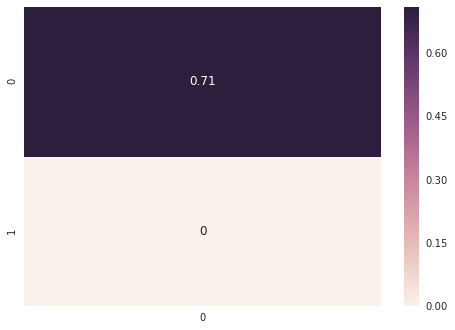

In [234]:
sns.heatmap(pearsonr(preds_1, preds_2), annot=True)

Suprisingly, the two models seem to be very poorly correlated, it actually looks like they produce opposite results, let's see what happens when I do a basic averaging ensemble of the two. Model 2 doesn't even have any positive guesses.

In [235]:
preds = np.squeeze((0.5*(preds_1+preds_2)))

In [236]:
keras.metrics.binary_accuracy(val_labels, preds).eval()

array(0.5315614342689514, dtype=float32)

In [237]:
keras.metrics.binary_crossentropy(np.array(val_labels), preds).eval()

array(2.472723709644562)

The accuracy hardly increased at all, but the loss was cut down substantially. In my experience, it's usually the opposite when you ensemble models together. It must be because both of these model are really bad.

### Stacked Bands

In [239]:
#this model is for the 2 stacked layers
def vgg_2():
    input_1 = Input(shape=(2,75,75))
    cnn = BatchNormalization()(input_1)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    cnn = Flatten()(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dense(64, activation='relu')(cnn)
    #cnn = Dropout(0)
    cnn = BatchNormalization()(cnn)
    cnn = Dense(1, activation='sigmoid')(cnn)
    
    vgg_2 = Model(input=input_1, output=cnn)
    vgg_2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return vgg_2

In [240]:
vgg_2 = vgg_2()

In [241]:
lr_anneal(vgg_2, trn_data, trn_labels, val_data, val_labels, 1e-3, 2, 1)

Train on 1303 samples, validate on 301 samples
Epoch 1/2
1303/1303 [==============================] - 75s - loss: 0.6026 - acc: 0.6884 - val_loss: 1.1134 - val_acc: 0.5316
Epoch 2/2
1303/1303 [==============================] - 75s - loss: 0.4125 - acc: 0.8150 - val_loss: 0.9108 - val_acc: 0.5316


In [242]:
vgg_2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_23 (InputLayer)            (None, 2, 75, 75)     0                                            
____________________________________________________________________________________________________
batchnormalization_49 (BatchNorm (None, 2, 75, 75)     300         input_23[0][0]                   
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 2, 77, 77)     0           batchnormalization_49[0][0]      
____________________________________________________________________________________________________
convolution2d_32 (Convolution2D) (None, 64, 75, 75)    1216        zeropadding2d_27[0][0]           
___________________________________________________________________________________________

In [243]:
vgg_2.save_weights(model_path + 'vgg_2.h5')

In [244]:
vgg_2.load_weights(model_path + 'vgg_2.h5')

### Data Augmentation

For some reason, data augmentation just seems like a nuisance to me, but it's inevitable and I should probably take care of it before I deal with the meatier, fun parts...

In [196]:
gen = ImageDataGenerator(rotation_range=180)

Once I move to the GPU instance and can rapidly train these things, I need to keep track of which augmentations work best so here is a nifty table

| Augmentation | Accuracy |  Loss  |
|--------------|----------|--------|
|   RR=180     |  .5316   | 1.4554 |

In [201]:
gen_flow_1 = gen.flow(trn_data_1, trn_labels)

In [203]:
vgg_b1.fit_generator(gen_flow_1, samples_per_epoch=len(trn_data_1), nb_epoch=2,
                    validation_data=(val_data_1, val_labels), nb_val_samples=len(val_data_1))

Epoch 1/2
1303/1303 [==============================] - 73s - loss: 0.7530 - acc: 0.6048 - val_loss: 3.6828 - val_acc: 0.5316
Epoch 2/2
1303/1303 [==============================] - 74s - loss: 0.6296 - acc: 0.6577 - val_loss: 1.4554 - val_acc: 0.5316


In [204]:
gen_flow_2 = gen.flow(trn_data_2, trn_labels)

In [205]:
vgg_b2.fit_generator(gen_flow_2, samples_per_epoch=len(trn_data_2), nb_epoch=2,
                    validation_data=(val_data_2, val_labels), nb_val_samples=len(val_data_2))

Epoch 1/2
1303/1303 [==============================] - 75s - loss: 0.6416 - acc: 0.6385 - val_loss: 2.5786 - val_acc: 0.5316
Epoch 2/2
1303/1303 [==============================] - 75s - loss: 0.5976 - acc: 0.6723 - val_loss: 1.6120 - val_acc: 0.5316


Accuracy didn't improve very much, but the loss has been just about cut in half, model still overfitting like mad though, which probably means dropout will be needed. Again I think it's only picking one class on the validation set

Apparently I can't add data augmentation if the image just has two channels, it needs to have 1,3,4. I'll have to wait to do data augmentation until I start adding more layers, I'm leaving the code here, but commenting it out until that time

In [251]:
#gen_flow = gen.flow(trn_data, trn_labels)

In [252]:
#vgg_2.fit_generator(gen_flow, samples_per_epoch=len(trn_data), nb_epoch=2,
#                    validation_data=(val_data, val_labels), nb_val_samples=len(val_data))

### Deeper VGG-like Model (with dropout)

Just about the same as before, but will another convolutional block, I've seen some people on kaggle using like 3-4 convolutional layers with maxpooling, but you're losing so much of the image if you do that. 75x75 image becomes like 5x5 after that many poolings layers, whereas after only two blocks I should have 18x18 images.

Also, I'm adding some dropout because I'll definitely need it sometime.

In [47]:
#this model is for the 2 stacked layers
def vgg_drop():
    input_1 = Input(shape=(2,75,75))
    
    #first convolutional block
    cnn = BatchNormalization()(input_1)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    
    #second convolutional block
    cnn = BatchNormalization()(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    
    #fc layers
    cnn = Flatten()(cnn)
    cnn = Dense(64, activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.2)(cnn)
    #if I decide I want it, here is another hidden layer to use
    #cnn = Dense(64, activation='relu')(cnn)
    #cnn = BatchNormalization()(cnn)
    #cnn = Dropout(0.2)(cnn)
    cnn = Dense(1, activation='sigmoid')(cnn)
    
    vgg_drop = Model(input=input_1, output=cnn)
    vgg_drop.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return vgg_drop

In [48]:
vgg_drop = vgg_drop()

In [49]:
lr_anneal(vgg_drop, trn_data, trn_labels, val_data, val_labels, 1e-3, 2, 1)

Train on 1168 samples, validate on 436 samples
Epoch 1/2
1168/1168 [==============================] - 15s - loss: 0.6315 - acc: 0.6550 - val_loss: 3.8363 - val_acc: 0.5115
Epoch 2/2
1168/1168 [==============================] - 14s - loss: 0.5249 - acc: 0.7354 - val_loss: 0.6809 - val_acc: 0.5367


In [66]:
def auto_anneal_vgg():
    lr_anneal(vgg_drop, trn_data, trn_labels, val_data, val_labels, 0.1, 1, 0)
    lr_anneal(vgg_drop, trn_data, trn_labels, val_data, val_labels, 0.01, 3, 0)
    lr_anneal(vgg_drop, trn_data, trn_labels, val_data, val_labels, 1e-3, 5, 0)
    lr_anneal(vgg_drop, trn_data, trn_labels, val_data, val_labels, 1e-4, 8, 0)
    lr_anneal(vgg_drop, trn_data, trn_labels, val_data, val_labels, 1e-5, 14, 0)
    return lr_anneal(vgg_drop, trn_data, trn_labels, val_data, val_labels, 1e-5, 1, 1)

In [67]:
auto_anneal_vgg()

Train on 1168 samples, validate on 436 samples
Epoch 1/1
1168/1168 [==============================] - 15s - loss: 0.4647 - acc: 0.7757 - val_loss: 0.4940 - val_acc: 0.7431


In [71]:
lr_anneal(vgg_drop, trn_data, trn_labels, val_data, val_labels, 1e-5, 20, 1)

Train on 1168 samples, validate on 436 samples
Epoch 1/20
1168/1168 [==============================] - 15s - loss: 0.4375 - acc: 0.7885 - val_loss: 0.4934 - val_acc: 0.7477
Epoch 2/20
1168/1168 [==============================] - 15s - loss: 0.4582 - acc: 0.7894 - val_loss: 0.4935 - val_acc: 0.7477
Epoch 3/20
1168/1168 [==============================] - 14s - loss: 0.4574 - acc: 0.7740 - val_loss: 0.4935 - val_acc: 0.7500
Epoch 4/20
1168/1168 [==============================] - 15s - loss: 0.4504 - acc: 0.7954 - val_loss: 0.4934 - val_acc: 0.7477
Epoch 5/20
1168/1168 [==============================] - 15s - loss: 0.4618 - acc: 0.7808 - val_loss: 0.4935 - val_acc: 0.7477
Epoch 6/20
1168/1168 [==============================] - 15s - loss: 0.4543 - acc: 0.7808 - val_loss: 0.4934 - val_acc: 0.7500
Epoch 7/20
1168/1168 [==============================] - 15s - loss: 0.4718 - acc: 0.7714 - val_loss: 0.4937 - val_acc: 0.7500
Epoch 8/20
1168/1168 [==============================] - 15s - loss: 0.4

Same deal with the validation accuracy being very biased, plus the model is still overfitting. However, this was only 2 epochs, doesn't include the incident angle or additional layers, no data augmentation, or pseudo-labeling, etc. Validation loss already started off much better with this model though. For right now I'm hesitant to add in more convolutional blocks, but I should do that eventually just to see if it improves. Maybe my intutition is wrong, but it just seems like so much lost data on an image that's already small

Currently this model is outperforming the cross-convolutional model

In [72]:
vgg_drop.save_weights(model_path + 'vgg_drop_1.h5')

In [73]:
vgg_drop.load_weights(model_path + 'vgg_drop_1.h5')

### Cross Convolutional?

Alright, this is what I've been building towards, there's a good chance it won't work at all because I really don't understand these things very well, but I'll give it a try because it seems like a neat idea.

### Model

In [27]:
from keras.layers import LocallyConnected1D

In [70]:
def cross_stacked():
    #input_1 will figure out how relationships between HH and HV affect classification
    act = 'elu'
    
    input_1 = Input(shape=(2,75*75))
    ibn = BatchNormalization()(input_1)
    #snb = ZeroPadding1D()(ibn)

    ups = Conv1D(64, 1)(ibn)
    bn1 = BatchNormalization()(ups)
    act1 = Activation(act)(bn1)
    flat1 = Flatten()(act1)
    
    #next I need to concatenate this layer onto the regular bands
    res = Reshape((2, 75, 75))(ibn)
    #per = Permute((3,1,2))(res)
    
    con = Conv2D(64, (3,3))(res)
    bn2 = BatchNormalization()(con)
    act2 = Activation(act)(bn2)
    mxp = GlobalMaxPooling2D()(act2)
    
    #flat2 = Flatten()(mxp)
    
    #cnn = concatenate([flat1, mxp])
    
    #cnn = Flatten()(merge)
    cnn = Dense(1, activation='sigmoid')(mxp)
    
    cross_stacked = Model(inputs=input_1, outputs=cnn)
    cross_stacked.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return cross_stacked

In [71]:
cs_model = cross_stacked()

In [72]:
cs_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 2, 5625)           0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 2, 5625)           22500     
_________________________________________________________________
reshape_9 (Reshape)          (None, 2, 75, 75)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 73, 73)        1216      
_________________________________________________________________
batch_normalization_37 (Batc (None, 64, 73, 73)        292       
_________________________________________________________________
activation_22 (Activation)   (None, 64, 73, 73)        0         
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 64)                0         
__________

In [73]:
def cs_quick_fit(lr, nb_epoch, verbose):
    cs_model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    cs_model.fit(trn_data_transpose, trn_labels, batch_size=64,
                 epochs=nb_epoch, verbose=verbose, validation_data=(val_data_transpose, val_labels))

In [ ]:
cs_quick_fit(1e-2, 5, 1)

Train on 1297 samples, validate on 307 samples
Epoch 1/5
1297/1297 [==============================] - 59s 45ms/step - loss: 0.8392 - acc: 0.5628 - val_loss: 1.6295 - val_acc: 0.4560
Epoch 2/5
 256/1297 [====>.........................] - ETA: 41s - loss: 0.6346 - acc: 0.6289

I'm amazed that it was even possible, now the moment of truth to see if it even works! I'm noticing that I should probably use 2 inputs, but leave the output to just 1, now that I understand how this works (sort of).

Good to see that after just 2 epochs I increased the validation accuracy by about 10% and reduced the loss by about .2. This seems to be a better than plain Jane model. (this is based on two inputs and two outputs). I don't think breaking off the input should matter, could just be random error from such a small number of epochs

Note cs_model_1.h5 has dropout 0.5 and 2 convolutional layers

In [120]:
cs_model.save_weights(model_path + 'cs_model_2.h5')

In [121]:
cs_model.load_weights(model_path + 'cs_model_2.h5')

### Parameter Tuning

It's difficult to see how the cross-convolution is actually performing with all the other layers involved, so I want to strip it down and see if I can tune the parameters (number of convolutions and stacked layers) that works best.

In [369]:
def simple_cs():
    #first input will figure out how to combine band_1 and band_2
    input_1 = Input(shape=(75*75,2))
    
    snb = BatchNormalization()(input_1)
    snb = ZeroPadding1D()(snb)
    snb = Convolution1D(3, 3, activation='relu')(snb)
    snb = BatchNormalization()(snb)
    snb = Dropout(0.5)(snb)
    
    #this is where path splits, I'll get output from this snb
    snb_out = Flatten()(snb)
    snb_out = Dense(64, activation='relu')(snb_out)
    snb_out = BatchNormalization()(snb_out)
    snb_out = Dropout(0.5)(snb_out)
    #snb_out = Dense(200, activation='relu')(snb_out)
    #snb_out = BatchNormalization()(snb_out)
    #snb_out = Dropout(0.25)(snb_out)
    snb_out = Dense(1, activation='sigmoid')(snb_out)
    
    simple_cs = Model(input=input_1, output=snb_out)
    simple_cs.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return simple_cs

In [370]:
simple_cs = simple_cs()

In [372]:
simple_cs.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
simple_cs.fit(trn_data_transpose, trn_labels, batch_size=64, 
              nb_epoch=1, verbose=1, validation_data=(val_data_transpose, val_labels))

Train on 1202 samples, validate on 402 samples
Epoch 1/1
1202/1202 [==============================] - 1s - loss: 0.0655 - acc: 0.9809 - val_loss: 0.3955 - val_acc: 0.8109


In [242]:
#1 is .3954 val loss, .81 val acc, 1 conv
#2 is .4991 val loss, .7687 val acc, drop 0.5
#3 is .5047 val loss, .7687 val acc, drop 0.3
#no dropout is awful
#4 is .4887 val loss, .7562 val acc, drop 0.3 on last
#5 is .4862 val loss, .7711 val acc, drop 0.25
simple_cs.save_weights(model_path + 'simple_cs_1.h5')

In [371]:
simple_cs.load_weights(model_path + 'simple_cs_1.h5')

The loss in this model is actually pretty close to what it was in the more complicated model, I need to considering keeping my models simpler. With two stacked layers I was at about .6 val loss. I notice that with 5 additional layers that the model starts to quickly overfit, this seems to suggest that the stacked layers are essentially just feeding in duplicates of the original image, hence the model sees each image about 3 times more. That being said the val_loss is still pretty decent, but val_acc indicates that 1 class is highly preferred.

### Splitting the VGG model

In [18]:
cs_layers = cs_model.layers
cs_conv_layer = [index for index,layer in enumerate(cs_layers) if type(layer) is Convolution1D][-1]

In [19]:
cs_conv_layer

3

In [233]:
cs_conv_layers = cs_layers[:cs_conv_layer+1]
cs_conv_model = Sequential(cs_conv_layers)

In [234]:
trn_features = cs_conv_model.predict(trn_data, batch_size=64)
val_features = cs_conv_model.predict(val_data, batch_size=64)

In [236]:
np.rear(trn_features)

AttributeError: 'module' object has no attribute 'permute'

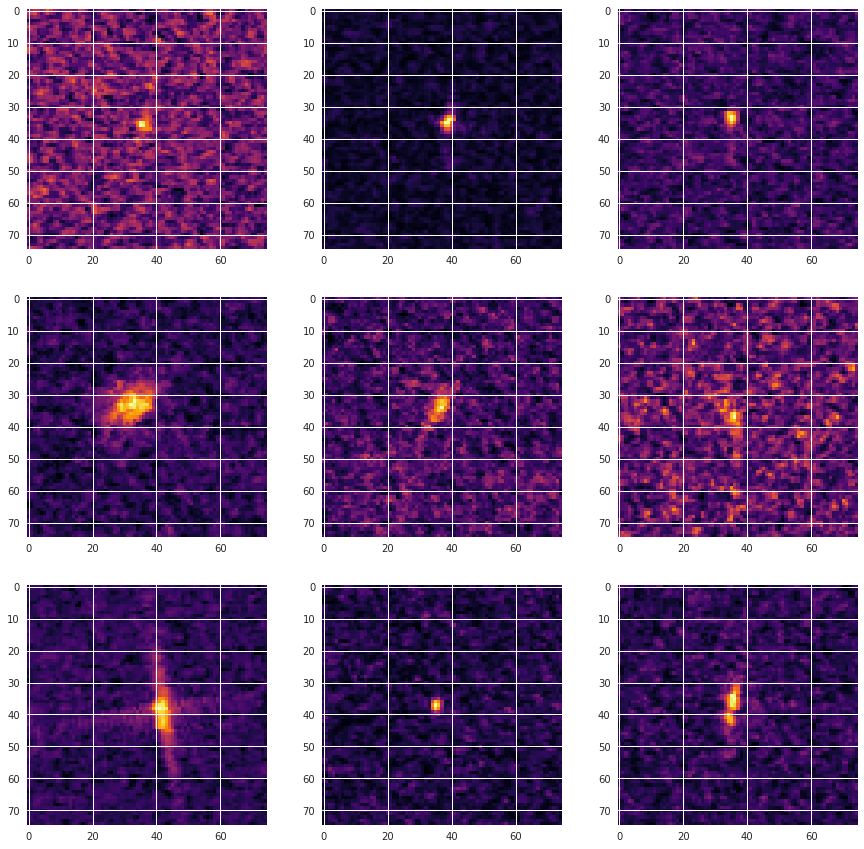

In [182]:
# Plot band_1
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(trn_features[:,:,:,:3], (1293,75,75,3))[i, :, :, 2]
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [255]:
val_features.shape

(402, 5625, 3)

In [413]:
def cs_main():
    #first input will figure out how to combine band_1 and band_2
    input_1 = Input(shape=(75*75,3))
    input_2 = Input(shape=(2,75,75))
    
    #next I need to concatenate this layer onto the regular bands
    snb = Reshape((75, 75, 3))(input_1)
    snb = Permute((3,1,2))(snb)
    snb = merge([input_2,snb], mode='concat', concat_axis=1)
    
    #first convolutional block
    cnn = BatchNormalization()(snb)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    
    #second convolutional block
    cnn = BatchNormalization()(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    
    #third convolutional block
    #cnn = BatchNormalization()(cnn)
    #cnn = ZeroPadding2D(padding=(1,1))(cnn)
    #cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    #cnn = ZeroPadding2D(padding=(1,1))(cnn)
    #cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    #cnn = MaxPooling2D((2,2))(cnn)
    
    #fc layers
    cnn = Flatten()(cnn)
    cnn = Dense(128, activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.3)(cnn)
    #if I decide I want it, here is another hidden layer to use
    cnn = Dense(64, activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.6)(cnn)
    cnn = Dense(1, activation='sigmoid')(cnn)
    
    cs_main = Model(input=[input_1, input_2], output=cnn)
    cs_main.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return cs_main

In [414]:
cs_main = cs_main()

In [415]:
cs_main.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
cs_main.fit([trn_features, trn_data], trn_labels, batch_size=64, nb_epoch=5, 
            verbose=1, validation_data=([val_features, val_data], val_labels))

Train on 1202 samples, validate on 402 samples
Epoch 1/5
1202/1202 [==============================] - 16s - loss: 0.9203 - acc: 0.5624 - val_loss: 1.5580 - val_acc: 0.5025
Epoch 2/5
1202/1202 [==============================] - 16s - loss: 0.8164 - acc: 0.6040 - val_loss: 6.1201 - val_acc: 0.4975
Epoch 3/5
1202/1202 [==============================] - 16s - loss: 0.7237 - acc: 0.6373 - val_loss: 4.5058 - val_acc: 0.4975
Epoch 4/5
1202/1202 [==============================] - 16s - loss: 0.6296 - acc: 0.6764 - val_loss: 7.1870 - val_acc: 0.4975
Epoch 5/5
1202/1202 [==============================] - 16s - loss: 0.6552 - acc: 0.6722 - val_loss: 8.0991 - val_acc: 0.4975


In [274]:
#2 .5881 val loss, .6393 val acc
cs_main.save_weights(model_path + 'cs_main_3.h5')

In [275]:
cs_main.load_weights(model_path + 'cs_main_3.h5')

### Data Augmentation

Because of the dimensionality requirement of the image data generator, I can't add augmentation until the cross-convolutional layers are very well trained. At that point I can separate out the convolutional parts and feed it into the data generator and then into the second half of the model. This is annoying, but if everything goes correctly, it should be worth it.

In [320]:
def cs_aug_main():
    #first input will figure out how to combine band_1 and band_2
    input_1 = Input(shape=(3,75,75))
    
    #first convolutional block
    cnn = BatchNormalization()(input_1)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(64, 3, 3, activation='relu')(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    
    #second convolutional block
    cnn = BatchNormalization()(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    cnn = ZeroPadding2D(padding=(1,1))(cnn)
    cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    cnn = MaxPooling2D((2,2))(cnn)
    
    #third convolutional block
    #cnn = BatchNormalization()(cnn)
    #cnn = ZeroPadding2D(padding=(1,1))(cnn)
    #cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    #cnn = ZeroPadding2D(padding=(1,1))(cnn)
    #cnn = Convolution2D(128, 3, 3, activation='relu')(cnn)
    #cnn = MaxPooling2D((2,2))(cnn)
    
    #fc layers
    cnn = Flatten()(cnn)
    cnn = Dense(128, activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.3)(cnn)
    #if I decide I want it, here is another hidden layer to use
    cnn = Dense(64, activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dropout(0.6)(cnn)
    cnn = Dense(1, activation='sigmoid')(cnn)
    
    cs_aug_main = Model(input=input_1, output=cnn)
    cs_aug_main.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return cs_aug_main

In [321]:
cs_aug_main = cs_aug_main()

In [329]:
gen = ImageDataGenerator(rotation_range=180, shear_range=5, zoom_range=0.2, channel_shift_range=5, 
                         fill_mode='nearest', horizontal_flip=True, vertical_flip=True)

Once I move to the GPU instance and can rapidly train these things, I need to keep track of which augmentations work best so here is a nifty table

| Augmentation | Accuracy |  Loss  |
|--------------|----------|--------|
|   RR=180     |  .5316   | 1.4554 |

In [330]:
trn_features_images = np.reshape(trn_features, (1202,75,75,3))
trn_features_images = np.transpose(trn_features_images, [0,3,2,1])
val_features_images = np.reshape(val_features, (402,75,75,3))
val_features_images = np.transpose(val_features_images, [0,3,2,1])

In [331]:
gen_flow = gen.flow(trn_features_images, trn_labels)

In [335]:
cs_aug_main.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
cs_aug_main.fit_generator(gen_flow, samples_per_epoch=len(trn_features), nb_epoch=8,
                         validation_data=(val_features_images, val_labels), nb_val_samples=len(val_features))

Epoch 1/8
1202/1202 [==============================] - 16s - loss: 0.6183 - acc: 0.6181 - val_loss: 0.6035 - val_acc: 0.5672
Epoch 2/8
1202/1202 [==============================] - 15s - loss: 0.6157 - acc: 0.6364 - val_loss: 0.5923 - val_acc: 0.6219
Epoch 3/8
1202/1202 [==============================] - 15s - loss: 0.6119 - acc: 0.6273 - val_loss: 0.5874 - val_acc: 0.6169
Epoch 4/8
1202/1202 [==============================] - 16s - loss: 0.6360 - acc: 0.6057 - val_loss: 0.6045 - val_acc: 0.5672
Epoch 5/8
1202/1202 [==============================] - 15s - loss: 0.6026 - acc: 0.6423 - val_loss: 0.6204 - val_acc: 0.5348
Epoch 6/8
1202/1202 [==============================] - 15s - loss: 0.6435 - acc: 0.5890 - val_loss: 0.6021 - val_acc: 0.5771
Epoch 7/8
1202/1202 [==============================] - 15s - loss: 0.5998 - acc: 0.6364 - val_loss: 0.6014 - val_acc: 0.5796
Epoch 8/8
1202/1202 [==============================] - 16s - loss: 0.6147 - acc: 0.6290 - val_loss: 0.5962 - val_acc: 0.5995


In [336]:
cs_aug_main.save_weights(model_path + 'cs_aug_main_1.h5')

In [337]:
cs_aug_main.load_weights(model_path + 'cs_aug_main_1.h5')

### Deeper Models

In [39]:
def get_model():
    bn_model = 0
    p_activation = 'elu'
    input_1 = Input(shape=(2, 75, 75), name="X_1")
    #input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(16, (1,1), activation=p_activation) (input_1)
    img_1 = Conv2D(16, (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(16, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(128, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    
    img_2 = Conv2D(128, (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D() (img_2)
    
    img_concat =  concatenate([img_1, img_2], axis=1)
    
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_concat) ))
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model(input_1,  output)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In [40]:
model = get_model()

In [45]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=2)
keras.optimizers.Adam.lr=1e-5

In [46]:
model.fit(trn_data, trn_labels, batch_size=64, epochs=20, callbacks=[reduce_lr], 
          validation_data=(val_data, val_labels))

Train on 1261 samples, validate on 343 samples
Epoch 1/20
1261/1261 [==============================] - 122s 96ms/step - loss: 0.3357 - acc: 0.8430 - val_loss: 0.2622 - val_acc: 0.8776
Epoch 2/20
1261/1261 [==============================] - 119s 94ms/step - loss: 0.3132 - acc: 0.8604 - val_loss: 0.2463 - val_acc: 0.8892
Epoch 3/20
1261/1261 [==============================] - 119s 94ms/step - loss: 0.3028 - acc: 0.8715 - val_loss: 0.2512 - val_acc: 0.8863
Epoch 4/20
1261/1261 [==============================] - 123s 97ms/step - loss: 0.2901 - acc: 0.8755 - val_loss: 0.3107 - val_acc: 0.8659
Epoch 5/20
1261/1261 [==============================] - 122s 97ms/step - loss: 0.2835 - acc: 0.8644 - val_loss: 0.2497 - val_acc: 0.8892
Epoch 6/20
1261/1261 [==============================] - 123s 97ms/step - loss: 0.2544 - acc: 0.8906 - val_loss: 0.2860 - val_acc: 0.8776
Epoch 7/20
1261/1261 [==============================] - 123s 98ms/step - loss: 0.2610 - acc: 0.8810 - val_loss: 0.2974 - val_acc: 0

In [50]:
model.save_weights(model_path + 'kernel_1.h5')

In [51]:
model.load_weights(model_path + 'kernel_1.h5')

### Starting Over

I also get ahead of myself and start making models that are too complicated before understaning my model

In [62]:
angle.shape

(1604,)

In [107]:
def model():
    act='elu'
    
    #angle_input = Input(shape=[1])
    
    input_1 = Input(shape=(3,75,75))
    cnn = BatchNormalization()(input_1)
    cnn = Convolution2D(filters=16, kernel_size=(3,3))(cnn)
    pool1 = MaxPooling2D((2,2))(cnn)
    #cnn = MaxPooling2D((2,2))(cnn)
    
    #1 block
    res1 = Convolution2D(16, kernel_size=(3,3), strides=(2,2))(cnn)
    
    #1 merge block
    merge1 = add([res1, pool1])
    bn1 = BatchNormalization()(merge1)
    act1 = Activation(act)(bn1)
    
    #2 block
    res21 = Conv2D(16,(3,3), strides=(2,2))(act1)
    
    #2 pool block
    res22 = ZeroPadding2D()(act1)
    res22 = AveragePooling2D((2,2))(res22)
    res22 = Conv2D(16,(3,3))(res22)
    
    #2 merge block
    merge2 = add([res21, res22])
    bn2 = BatchNormalization()(merge2)
    act2 = Activation(act)(bn2)
    
    #3 two deep block
    res311 = ZeroPadding2D()(act2)
    res312 = Conv2D(64,(3,3))(res311)
    res313 = Conv2D(64,(3,3), strides=(2,2))(res312)
    
    #3 one deep block
    res321 = Conv2D(64,(3,3), strides=(2,2))(act2)
    
    #3 average pool 1 deep block
    res331 = AveragePooling2D((2,2))(act2)
    res332 = ZeroPadding2D()(res331)
    res333 = Conv2D(64,(3,3))(res332)
    
    #3 merge block
    merge3 = add([res333, res321, res313])
    bn3 = BatchNormalization()(merge3)
    act3 = Activation(act)(bn3)
    gmp = GlobalAveragePooling2D()(act3)
    
    #cross-conv block
    #ibn = BatchNormalization()(input_1)
    #rshp = Reshape((3, 75*75))(ibn)
    #ups = Conv1D(32, 3)(rshp)
    #bn1 = BatchNormalization()(ups)
    #act1 = Activation(act)(bn1)
    #flat1 = Flatten()(act1)
    
    #out = Flatten()(act3)
    #out = concatenate([gmp, flat1])
    
    
    out = Dense(1, activation='sigmoid')(gmp)
    
    model = Model(inputs=input_1, outputs=out)
    #model = Model(inputs=[input_1, angle_input], outputs=out)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [108]:
model = model()

In [109]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 3, 75, 75)    0                                            
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 3, 75, 75)    300         input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 16, 73, 73)   448         batch_normalization_82[0][0]     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 16, 36, 36)   2320        conv2d_74[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [110]:
keras.optimizers.Adam.lr=1e-3
model.fit(trn_data, trn_labels, batch_size=64, epochs=4, 
          verbose=1, validation_data=(val_data, val_labels))

Train on 1297 samples, validate on 307 samples
Epoch 1/4
1297/1297 [==============================] - 14s 11ms/step - loss: 0.7639 - acc: 0.5073 - val_loss: 0.6920 - val_acc: 0.5472
Epoch 2/4
1297/1297 [==============================] - 13s 10ms/step - loss: 0.6716 - acc: 0.5497 - val_loss: 0.8219 - val_acc: 0.5440
Epoch 3/4
 832/1297 [==================>...........] - ETA: 4s - loss: 0.6471 - acc: 0.5889

KeyboardInterrupt: 

<tr>
<td># Conv</td>
<td># Conv/Block</td>
<td># Filter</td>
<td>Kernel</td>
<td>MaxPool</td>
<td>FC units</td>
<td>Dropout</td>
<td>Val Loss</td>
<td>Val Acc</td>
<td>Result</td>
</tr>
<tr>
<td>1</td>
<td>1</td>
<td>16</td>
<td>(3,3)</td>
<td>(2,2)</td>
<td>1</td>
<td>NA</td>
<td>.3941</td>
<td>.8135</td>
<td>100% train fit</td>
</tr>
<tr>
<td>1</td>
<td>1</td>
<td>16</td>
<td>(5,5)</td>
<td>(2,2)</td>
<td>1</td>
<td>NA</td>
<td>.3604</td>
<td>.8392</td>
<td>100% train fit</td>
</tr>
<tr>
<td>1</td>
<td>1</td>
<td>16</td>
<td>(5,5)</td>
<td>(4,4)</td>
<td>1</td>
<td>NA</td>
<td>.3081</td>
<td>.8585</td>
<td>100% train fit</td>
</tr>
<tr>
<td>1</td>
<td>1</td>
<td>16, l2(0.1)</td>
<td>(5,5)</td>
<td>(4,4)</td>
<td>1</td>
<td>NA</td>
<td>.3700</td>
<td>.8521</td>
<td>Overfits slowly with w2 regularizer</td>
</tr>

In [103]:
gen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True)

Once I move to the GPU instance and can rapidly train these things, I need to keep track of which augmentations work best so here is a nifty table

|         Augmentation         | Accuracy |  Loss  |
|------------------------------|----------|--------|
|            RR=180            |  .5316   | 1.4554 |
|        RR=180,HFVF=T         |  .8703   | 0.2888 |

In [104]:
gen_flow = gen.flow(trn_data, trn_labels)

In [122]:
keras.optimizers.Adam.lr=1e-1
model.fit_generator(gen_flow, steps_per_epoch=len(trn_data)/64, epochs=20, callbacks=[reduce_lr],
                         validation_data=(val_data, val_labels), validation_steps=len(val_data)/64)

Epoch 1/20
20/20 [==============================] - 79s 4s/step - loss: 0.5406 - acc: 0.7851 - val_loss: 0.8683 - val_acc: 0.8143
Epoch 2/20
20/20 [==============================] - 77s 4s/step - loss: 0.5022 - acc: 0.7875 - val_loss: 1.0582 - val_acc: 0.7655
Epoch 3/20
20/20 [==============================] - 77s 4s/step - loss: 0.4757 - acc: 0.8016 - val_loss: 0.8365 - val_acc: 0.7818
Epoch 4/20
20/20 [==============================] - 75s 4s/step - loss: 0.4915 - acc: 0.7903 - val_loss: 1.0011 - val_acc: 0.7785
Epoch 5/20
20/20 [==============================] - 78s 4s/step - loss: 0.4714 - acc: 0.7984 - val_loss: 0.6631 - val_acc: 0.8013
Epoch 6/20
20/20 [==============================] - 75s 4s/step - loss: 0.4576 - acc: 0.7590 - val_loss: 0.8131 - val_acc: 0.8013
Epoch 7/20
20/20 [==============================] - 78s 4s/step - loss: 0.4519 - acc: 0.7984 - val_loss: 0.5903 - val_acc: 0.8111
Epoch 8/20
20/20 [==============================] - 75s 4s/step - loss: 0.4136 - acc: 0.80

KeyboardInterrupt: 

cnn2 has val_loss .3441 and val_acc of .8533

In [ ]:
model.save_weights(model_path + 'cnn103.h5')

In [ ]:
model.load_weights(model_path + 'cnn103.h5')

### Test Time Augmentation

## VGG Model

In [53]:
from keras.applications import VGG16

In [57]:
batch_size=64

In [58]:
K.set_image_data_format('channels_last')

In [59]:
vgg = VGG16(include_top=False, input_shape=(75,75,3))

In [62]:
#trn_features = vgg.predict(trn_data, batch_size=batch_size, verbose=1)
#val_features = vgg.predict(val_data, batch_size=batch_size, verbose=1)

1301/1301 [==============================] - 229s 176ms/step


In [63]:
save_array(path+'trn_features.bc', trn_features)
save_array(path+'val_features.bc', val_features)

In [64]:
trn_features = load_array(path+'trn_features.bc')
val_features = load_array(path+'val_features.bc')

### Convolutions without retraining

In [53]:
trn_features = vgg.predict(trn_data[:1])
val_features = vgg.predict(val_data)

In [ ]:
vgg.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
vgg.fit(trn_data, batches.classes, batch_size=64, epochs=2, 
        validation_data=(val_data, val_batches.classes))

## Visualization

In [39]:
model.summary()

AttributeError: 'function' object has no attribute 'summary'

In [118]:
model_layers = model.layers
conv_layers = [index for index,layer in enumerate(model_layers) if type(layer)==Conv2D]
dense_layers = [index for index,layer in enumerate(model_layers) if type(layer)==Dense]

In [124]:
from vis.backprop_modifiers import *

In [202]:
img = visualize_activation(model, layer_idx=conv_layers[3], filter_indices=None, seed_input=trn_data[4])[:,:,0]

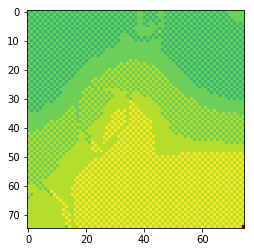

In [203]:
plt.imshow(img)

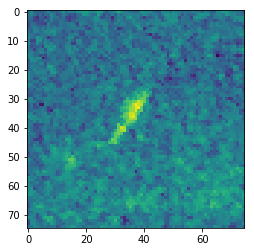

In [201]:
plt.imshow(trn_data[4][0,:,:])

## Validation

Instead of doing a bunch of different validation sections for each model, I'll just make one and try to keep good record of how each model performs in this section.

In [137]:
preds = np.squeeze(ex_top.predict([ex_val_features,val_features,rn_val_features]))

In [138]:
preds = np.round(preds)

In [139]:
incorrect = np.where(preds!=val_labels)[0]

In [140]:
incorrect.shape

(49,)

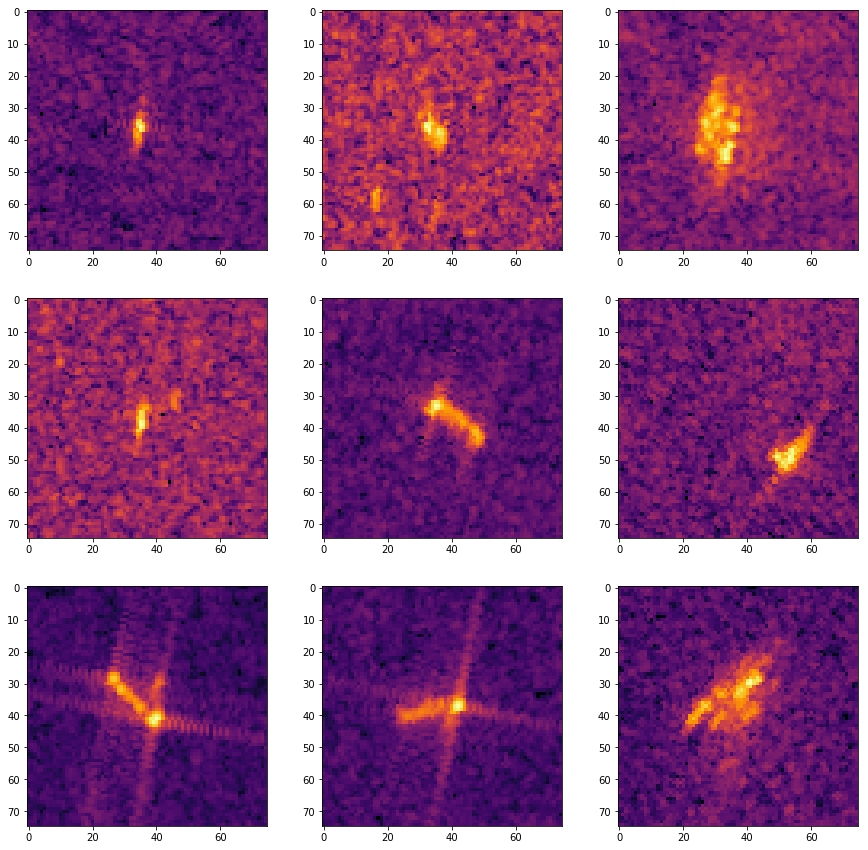

In [144]:
# Plot band_1
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = val_data[i,:,:,0]
    ax.imshow(arr,cmap='inferno')
    
plt.show()

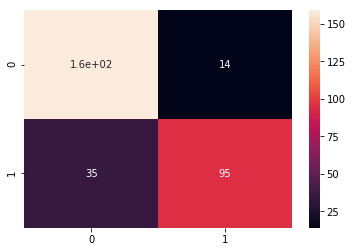

In [145]:
cm = confusion_matrix(val_labels, preds)
sns.heatmap(cm, annot=True)

## Resnet

In [65]:
from keras.applications import ResNet50

In [90]:
rn = ResNet50(include_top=False, input_shape=(197,197,3))

In [86]:
def padding():
    pad = Sequential([
        ZeroPadding2D(padding=(61,61), input_shape=(75,75,3))
        #Flatten(),
        #Dense(1, activation='sigmoid')
    ])
    
    return pad

In [87]:
pad = padding()

In [93]:
#padded_trn_data = pad.predict(trn_data)
#padded_val_data = pad.predict(val_data)

In [94]:
#rn_trn_features = rn.predict(padded_trn_data, batch_size=batch_size, verbose=1)
#rn_val_features = rn.predict(padded_val_data, batch_size=batch_size, verbose=1)

303/303 [==============================] - 240s 793ms/step


In [95]:
#save_array(path+'rn_trn_features.bc', rn_trn_features)
#save_array(path+'rn_val_features.bc', rn_val_features)

In [96]:
rn_trn_features = load_array(path+'rn_trn_features.bc')
rn_val_features = load_array(path+'rn_val_features.bc')

In [97]:
rn_trn_features.shape

(1301, 1, 1, 2048)

## Xception

In [18]:
from keras.applications import xception

In [19]:
from keras.layers import GlobalAveragePooling2D

In [20]:
ex = xception.Xception(include_top=False, input_shape=(75,75,3))

In [101]:
#ex_trn_features = ex.predict(trn_data, batch_size=32, verbose=1)
#ex_val_features = ex.predict(val_data, batch_size=32, verbose=1)

303/303 [==============================] - 38s 125ms/step


In [102]:
#save_array(path+'ex_trn_features.bc', ex_trn_features)
#save_array(path+'ex_val_features.bc', ex_val_features)

In [91]:
ex_trn_features = load_array(path+'ex_trn_features.bc')
ex_val_features = load_array(path+'ex_val_features.bc')

In [92]:
ex_trn_features.shape

(1301, 3, 3, 2048)

In [203]:
p_activation='relu'
bn_model=0
def ex_top2():
    input_1 = Input(shape=(3,3,2048))
    x1 = BatchNormalization()(input_1)
    x1 = GlobalAveragePooling2D()(x1)
    
    input_2 = Input(shape=(75,75,3))
    img_1 = Conv2D(16, (1,1), activation=p_activation) (input_2)
    img_1 = Conv2D(16, (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(16, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(128, (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    img_2 = Conv2D(128, (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_2))
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D() (img_2)
    
    x2 =  concatenate([img_1, img_2], axis=1)
    
    #dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_concat) ))
    #dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    #output = Dense(1, activation="sigmoid")(dense_ayer)
    
    input_3 = Input(shape=(2,2,512))
    #x3 = Conv2D(2048, (1,1), activation='relu')(input_3)
    x3 = BatchNormalization()(input_3)
    x3 = GlobalAveragePooling2D()(x3)
    
    #input_4 = Input(shape=(1,1,2048))
    #x4 = BatchNormalization()(input_4)
    #x4 = Flatten()(x4)
    
    merge = concatenate([x1,x2,x3])
    #merge = concatenate([x1,x3,x4])
    
    out = Dense(256, activation='relu')(merge)
    out = BatchNormalization()(out)
    out = Dropout(0.8)(out)
    #out = Dense(128, activation='relu')(out)
    #out = BatchNormalization()(out)
    #out = Dropout(0.8)(out)
    out = Dense(1, activation='sigmoid')(out)
    #out = Dense(1, activation='sigmoid')(x2)
    
    ex_top2 = Model([input_1,input_3,input_2], out)
    #ex_top2 = Model([input_1,input_3,input_4], out)
    
    return ex_top2

In [204]:
ex_top = ex_top2()

In [208]:
ex_top.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 75, 75, 16)   64          input_65[0][0]                   
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 73, 73, 16)   2320        conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 71, 71, 16)   2320        conv2d_44[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [205]:
ex_top.compile(optimizer=Adam(lr=1e-1), loss='binary_crossentropy', metrics=['accuracy'])

In [206]:
reduce_lr = ReduceLROnPlateau(patience=1)

In [207]:
ex_top.fit([ex_trn_features, trn_features, trn_data], trn_labels, batch_size=64, epochs=5, verbose=1, callbacks=[reduce_lr],
          validation_data=([ex_val_features, val_features, val_data], val_labels))

Train on 1301 samples, validate on 303 samples
Epoch 1/5
1301/1301 [==============================] - 113s 87ms/step - loss: 1.9509 - acc: 0.5073 - val_loss: 9.0965 - val_acc: 0.4290
Epoch 2/5
1301/1301 [==============================] - 111s 85ms/step - loss: 1.2336 - acc: 0.5173 - val_loss: 3.6060 - val_acc: 0.4290
Epoch 3/5
1301/1301 [==============================] - 109s 84ms/step - loss: 0.8770 - acc: 0.5012 - val_loss: 0.8285 - val_acc: 0.4290
Epoch 4/5
1301/1301 [==============================] - 107s 82ms/step - loss: 0.8247 - acc: 0.5050 - val_loss: 2.0992 - val_acc: 0.4290
Epoch 5/5
 832/1301 [==================>...........] - ETA: 37s - loss: 0.8470 - acc: 0.4844

KeyboardInterrupt: 

## Retrain Xception

In [107]:
XX = ex.input
YY = ex.layers[-1].output
ext = Model([XX], [YY])

In [140]:
ex.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 37, 37, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 37, 37, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [154]:
ex_out = ex.get_layer('block14_sepconv2_act').output

In [157]:
def top():
    input1 = Input(shape=(3,3,2048))
    x = Conv2D(1, (3,3), padding='same')(input1)
    x = GlobalAveragePooling2D()(x)
    x = Activation('relu')(x)
    
    top = Model(input1, x)
    
    return top

In [158]:
top = top()

In [159]:
for layer in ex.layers: layer.trainable=True

In [160]:
full_ex = top(ex_out)
ext = Model(ex.input, full_ex)

In [162]:
ext.compile('Adam', 'binary_crossentropy', ['accuracy'])

In [163]:
ext.fit(trn_data, trn_labels, epochs=5, batch_size=batch_size,
        validation_data=(val_data, val_labels))

Train on 1301 samples, validate on 303 samples
Epoch 1/5
  64/1301 [>.............................] - ETA: 9:09 - loss: 2.0563 - acc: 0.5156

KeyboardInterrupt: 

In [170]:
gen = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

In [171]:
flow = gen.flow(trn_data, trn_labels, batch_size=batch_size)

In [172]:
ext.fit_generator(flow, steps_per_epoch=len(trn_data)/batch_size, epochs=5,
                  validation_data=(val_data, val_labels), validation_steps=len(val_data)/batch_size)

Epoch 1/5
 1/20 [>.............................] - ETA: 7:35 - loss: 2.9112 - acc: 0.5000

KeyboardInterrupt: 

## Data Augmentation

In [45]:
from tqdm import tqdm

In [50]:
epochs = 4
batch_size = 64
gen = image.ImageDataGenerator(zoom_range=0.5, horizontal_flip=True, vertical_flip=True)
#gen_flow = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=False)
#try:
for e in range(epochs):
    print('-'*40)
    for b in tqdm(range(20)):
        f = b * batch_size
        l = (b+1) * batch_size
        #print('at gen flow')
        gen_flow = gen.flow(np.array(trn_data[f:l]), np.array(trn_labels[f:l]), batch_size=batch_size, shuffle=False)
        #print('at trn_batch')
        trn_batch = np.array(next(gen_flow)[0])
        #print('at vgg trn batch')
        vgg_trn_batch = vgg.predict(trn_batch, steps=1)
        #print('at ex trn batch')
        ex_trn_batch = ex.predict(trn_batch, steps=1)
        #print('at batch label')
        batch_label = np.array(trn_labels[f:l])
            
        ex_top.train_on_batch([ex_trn_batch, vgg_trn_batch, trn_batch], batch_label)

    print("")    
    lossv, accuracyv = ex_top.evaluate([ex_val_features, val_features, val_data], val_labels, verbose=1)
    print('Epoch: {0} | Loss: {1} | Acc: {2}'.format(e, lossv, accuracyv))
        
#except KeyboardInterrupt:
    #pass


  0%|          | 0/20 [00:00<?, ?it/s]

----------------------------------------



Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|██████████| 20/20 [07:33<00:00, 22.65s/it]



309/309 [==============================] - 2s 6ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.362543345944 | Acc: 0.828478965366
----------------------------------------


100%|██████████| 20/20 [07:31<00:00, 22.59s/it]


 32/309 [==>...........................] - ETA: 1s

309/309 [==============================] - 2s 5ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.354540621868 | Acc: 0.83171521132
----------------------------------------


100%|██████████| 20/20 [07:34<00:00, 22.75s/it]


 32/309 [==>...........................] - ETA: 1s

309/309 [==============================] - 2s 5ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2 | Loss: 0.34855047312 | Acc: 0.828478965366
----------------------------------------


 30%|███       | 6/20 [02:13<05:12, 22.31s/it]

KeyboardInterrupt: 